In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from xhistogram.xarray import histogram
%matplotlib inline

In [95]:
# Load the data
# (from restart)
config = 'OM4p25_JRA55do1.4_0netfw_cycle6'
rootdir = '/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.08.08/'+config+'/gfdl.ncrc4-intel16-prod/pp/'
pp = 'ocean_monthly'
localdir = '/ts/monthly/1yr/'
filename = pp+'.*.nc'
ds = xr.open_mfdataset(rootdir+pp+localdir+filename).isel(time=0)
grid = xr.open_dataset(rootdir+pp+'/'+pp+'.static.nc')
# Specify some constants
Cp = 3992.
rho0 = 1035.

## Salt and freshwater

In [96]:
salty = ['prlq', 'prsn','evs','friver','ficeberg','fsitherm','sfdsi','wfo','net_massin','net_massout',
        'vprec','salt_flux_added']

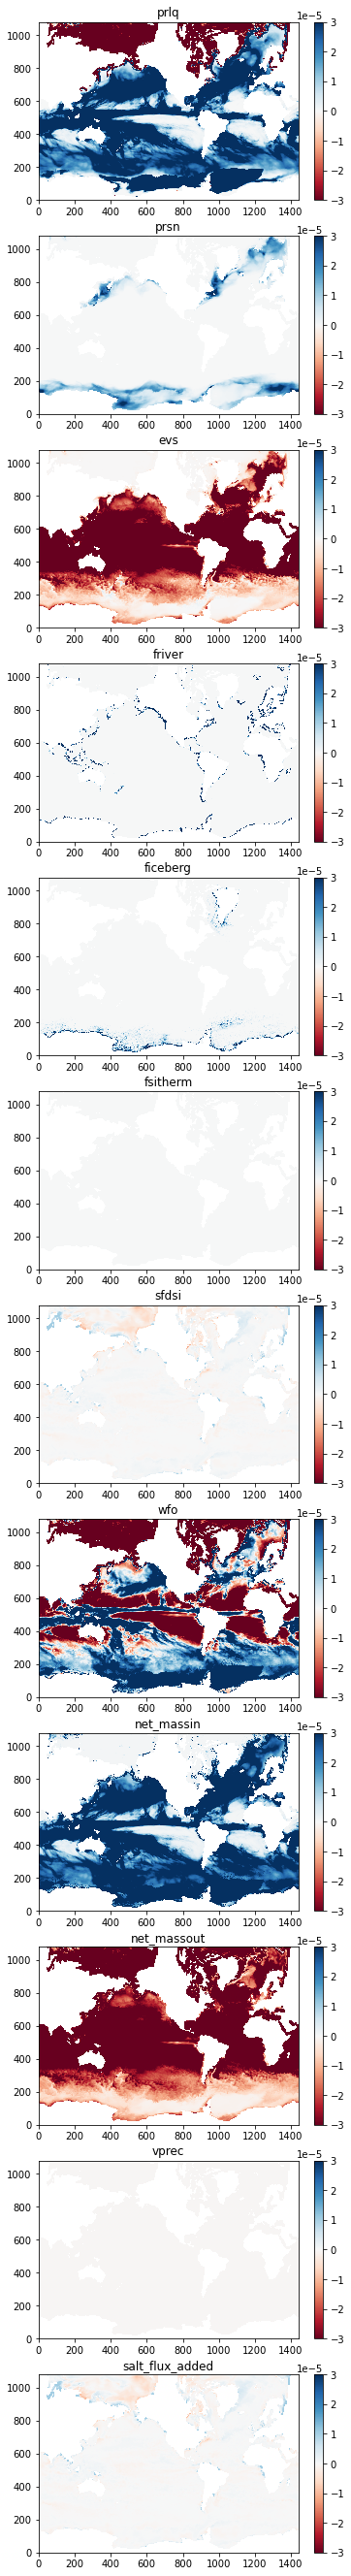

In [97]:
n = len(salty)
fig,ax=plt.subplots(figsize=(6,n*4),nrows=n)
for i in range(n):
    im=ax[i].pcolormesh(ds[salty[i]],cmap='RdBu',vmin=-3E-5,vmax=3E-5)
    plt.colorbar(im,ax=ax[i])
    ax[i].set_title(salty[i])

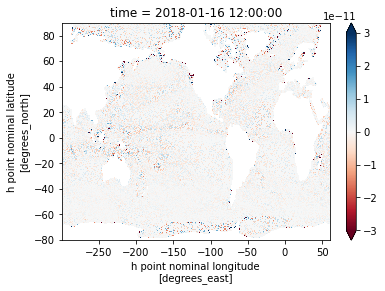

In [100]:
(ds['net_massin']+ds['net_massout']-ds['wfo']).plot(vmin=-3E-11,vmax=3E-11,cmap='RdBu')

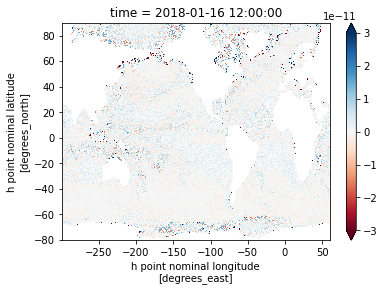

In [104]:
(ds['prlq']+ds['prsn']
   +ds['friver']+ds['ficeberg']+ds['fsitherm']
   +ds['evs']
   +ds['vprec']
    -ds['wfo']).plot(vmin=-3E-11,vmax=3E-11,cmap='RdBu')

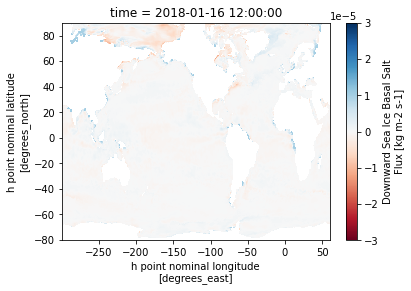

In [108]:
ds['sfdsi'].plot(vmin=-3E-5,vmax=3E-5,cmap='RdBu')

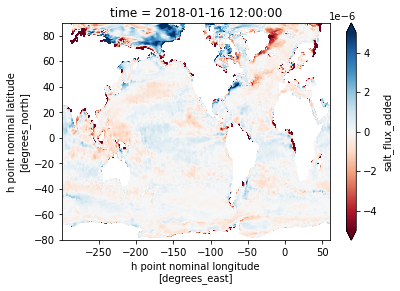

In [113]:
(-1*ds['salt_flux_added']).plot(vmin=-5E-6,vmax=5E-6,cmap='RdBu')

## What I'm finding out
- wfo = net_massin - net_massout; to machine precision
- ice melt/formation is _included_ in `prlq` (see diag_table from this OM4 run)
    - see here https://github.com/NOAA-GFDL/MOM6-examples/blob/a2162e49fffaeed79201a6e26f25c108f1f7ebb8/ice_ocean_SIS2/OM4_025/diag_table.MOM6_spinup#L345
- the term `salt_flux_added` appears to be the negative of the other two
- interesting correspondence between `sfdsi` and `salt_flux_added`; it looks like `sfdsi` might have restoring salt flux added to it 

- omitting both of these terms leaves a very close balance between `wfo` and all the other terms (v close to closed at machine precision)
- But, including both of these two terms leaves a bizarre pattern with a large

***
OK, have a look here https://github.com/NOAA-GFDL/MOM6/blob/136afce0b872a996289da2b50b6af8dc59d64365/src/core/MOM_forcing_type.F90#L1825
Seems like the CMOR naming could be a little confusing, perhaps better diagnostics could be used.

`sfdsi` is in fact `'Net salt flux into ocean at surface (restoring + sea-ice)'`

***

Going back to my original issue - perhaps this issue here is that I am attempting to connect the _salt_ tendency with a salinity tendency... is there a fundamental flaw here, particularly in relation to the boundary forcing, since addition of freshwater cannot change salt, so all I'm getting is the restoring term.

Do I need the thickness tendency at the same time, to reconstruct the salinity tendency?